In [170]:
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
%matplotlib inline

from mesa import Agent,Model
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

In [171]:
class Firefly(Agent):
    def __init__(self,unique_id,pos,model):
        super().__init__(unique_id,model)
        self.pos = pos
        self.clock = self.random.randint(1,self.model.cycle_length)

    def is_flashing(self):
        return self.clock <= self.model.flash_length

    def step(self):
        # self.clock = self.clock+1
        self._next = self.clock+1
        if self._next > self.model.cycle_length:
            self._next = 1

        if not self.is_flashing():
            neighbours = self.model.grid.get_neighbors(self.pos,True)
            for neighbour in neighbours:
                if neighbour.is_flashing():
                    self._next = self.model.flash_length + 1

    def advance(self):
        self.clock = self._next
        self.move()

    def move(self):
        next_moves = self.model.grid.get_neighborhood(self.pos,True,True)
        next_move = self.random.choice(next_moves)
        self.model.grid.move_agent(self,next_move)

In [172]:
class FireflyWorld(Model):
    def __init__(self, height=30, width=30, cycle_length=10, flash_length=1):
        super().__init__()
        self.cycle_length = cycle_length
        self.flash_length = flash_length

        self.schedule = SimultaneousActivation(self)
        self.grid = MultiGrid(height,width, torus=True)
        self.dc = DataCollector({"Flashing":lambda m: self.count_flashing()})

        for i in range(200): #200 is the number of fly
            pos = (self.random.randint(0,width-1),
                   self.random.randint(0,height-1))
            f = Firefly(self.next_id(),pos,self)
            self.grid.place_agent(f,pos)
            self.schedule.add(f)

        self.running = True

    def step(self):
        self.schedule.step()
        self.dc.collect(self)

        if self.schedule.time > 500:
            self.running = False

    def count_flashing(self):
        count = 0
        for f in self.schedule.agents:
            if f.is_flashing():
                count+=1
        return count

In [173]:
ff = FireflyWorld(30,30,10,3)

In [174]:
ff.run_model()

In [175]:
result = ff.dc.get_model_vars_dataframe()

In [176]:
result

,Flashing
0,55
1,43
2,31
3,23
4,18
...,...
496,40
497,26
498,31
499,22


In [177]:
result["time"] = np.linspace(0,len(result) - 1, len(result))

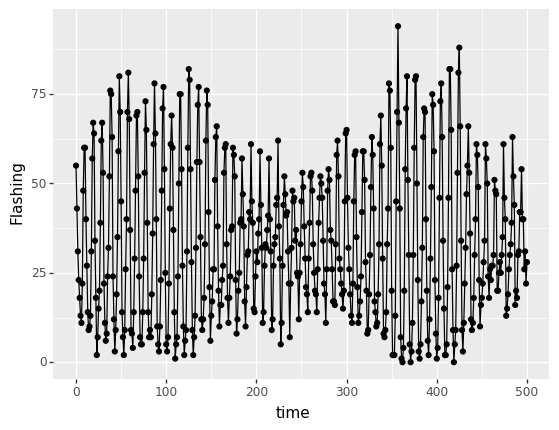

<ggplot: (156799774193)>

In [178]:
ggplot(result,aes(x="time",y="Flashing"))\
+geom_line() + geom_point()

Video to fix: https://www.youtube.com/watch?v=MpyA_RKZ6A8&list=PLBnmWnLGF3aaNXgdunV3yiNchqfEEJfHP&index=4